In [3]:
import numpy as np
import healpy as hp
import histlite as hl
import matplotlib.pyplot as plt

In [4]:
#Load MC
mc = np.load('data/level2/sim/npy/Level2_sim.npy', allow_pickle=True)
#mc = np.load('', allow_pickle=True)
mc_pst = np.load('/data/ana/PointSource/PS/version-004-p02/dataset/IC86_2016_MC.npy', allow_pickle=True)
print(mc.dtype)

#Load template 
template = np.load('templates/Fermi-LAT_pi0_map.npy', allow_pickle=True)

[('run', '<i8'), ('event', '<i8'), ('subevent', '<i8'), ('ra', '<f8'), ('dec', '<f8'), ('azi', '<f8'), ('zen', '<f8'), ('time', '<f8'), ('logE', '<f8'), ('angErr', '<f8'), ('true_ra', '<f8'), ('true_dec', '<f8'), ('true_azi', '<f8'), ('true_zen', '<f8'), ('true_energy', '<f8'), ('true_angErr', '<f8'), ('oneweight', '<f8')]


In [5]:
def angular_distance(lon1,lat1,lon2,lat2):
    """
    calculate the angular distince along the great circle
    on the surface of a shpere between the points
    (`lon1`,`lat1`) and (`lon2`,`lat2`)

    This function Works for equatorial coordinates
    with right ascension as longitude and declination
    as latitude. This function uses the Vincenty formula
    for calculating the distance.

    Parameters
    ----------
    lon1 : array_like
      longitude of first point in radians
    lat1 : array_like
      latitude of the first point in radians
    lon2 : array_like
      longitude of second point in radians
    lat2 : array_like
      latitude of the second point in radians

    """

    c1 = np.cos(lat1)
    c2 = np.cos(lat2)
    s1 = np.sin(lat1)
    s2 = np.sin(lat2)
    sd = np.sin(lon2-lon1)
    cd = np.cos(lon2-lon1)

    return np.arctan2(
        np.hypot(c2*sd,c1*s2-s1*c2*cd),
        s1*s2+c1*c2*cd
        )


In [4]:
pst_angerr = angular_distance(mc_pst['trueRa'], mc_pst['trueDec'], mc_pst['ra'], mc_pst['dec'])

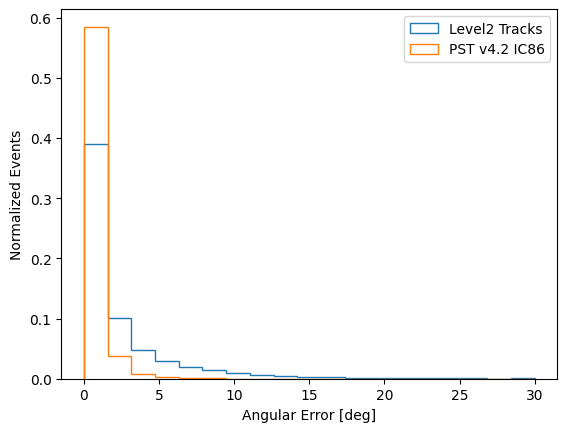

In [14]:
bins = np.linspace(0,30,20)
weights = 1e-18 * mc['oneweight'] * mc['true_energy']**(-2)
weights_pst = 1e-18 * mc_pst['ow'] * mc_pst['trueE']**(-2)
#Weights are different though, so maybe not a good 1:1 comparison
plt.figure(facecolor='w')
plt.hist(np.degrees(mc['angErr']), bins=bins, histtype='step', label='Level2 Tracks', density=True, weights=weights)
plt.hist(np.degrees(mc_pst['angErr']), bins=bins, histtype='step', label='PST v4.2 IC86', density=True, weights=weights_pst)
plt.xlabel('Angular Error [deg]')
plt.ylabel('Normalized Events')
plt.legend()
plt.show()

In [3]:
mc.shape

(470924,)

In [26]:
#Adapted from Steve's PONE calc_effa_from_nugen.ipynb function effa2d
d_logE = .2
d_zen = 2 * np.pi * np.diff(np.linspace(-1,1,50))[0] 
bins = (np.arange(2,7.01,d_logE), np.linspace(-1,1,50))

area = (1/(np.log(10)) * (mc['oneweight'] / (mc['true_energy'] * d_zen * d_logE))) #CHECK UNITS FOR DIFF USAGE
#range = [(-1,1), (3,6)]
h2d = hl.hist((np.log10(mc['true_energy']), np.sin(mc['true_dec'])),
          weights=area,
          bins=bins)

In [ ]:
#1d hist?
dec_idx = np.digitize(np.sin(mc['true_dec']), np.linspace(-1,1,50))
dec_mask = (dec_idx == 25)
h1d = hl.hist(np.log10(mc['true_energy'])[dec_mask],
          weights=area[dec_mask],
          bins=np.arange(2,7.01,d_logE))

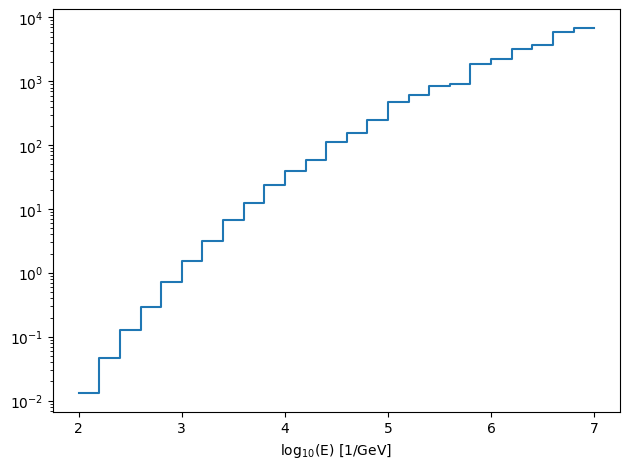

In [13]:
#Visualize
fig, ax = plt.subplots()
hl.plot1d(ax, h1d)
ax.semilogy()
ax.set_xlabel('log$_{10}$(E) [1/GeV]')
ax.set_title('')
#ax.set_aspect('equal')
plt.tight_layout()

In [8]:
def effa_plot_notlogged(ax, mc, deg_min = -90, deg_max = 90, 
                        selection_eff = 1,label = '', color = 'k', ls = '-'):
    a = mc
    mask = (a['true_dec'] < np.radians(deg_max)) & (a['true_dec'] > np.radians(deg_min))
    
    dlogE=.1
    bins = 10**np.arange(2,7.01,dlogE)
    solid_angle=2*np.pi*(np.cos(np.radians(deg_min))) - np.cos(np.radians(deg_max))
    solid_angle = np.abs(solid_angle)
    area=  (1/(1e4*np.log(10)) * (a['oneweight'][mask] / ( (a['true_energy'][mask]) *  solid_angle *  dlogE)))
    #(1/1e4*np.log(10)) *
    h = hl.hist((a['true_energy'][mask]), 
                #weights=dats.effective_area[mask] / (solid_angle * dlogE), 
                weights = selection_eff *area,
                bins=bins);
    hl.plot1d(h, histtype='step', linewidth=2, color=color, label=label, ls = ls, log=True)
    ax.loglog()

    ax.grid()
    #ax.legend(loc='lower right')
    ax.set_ylabel('$A_\mathsf{Eff}$ [$m^2$]')
    ax.set_xlabel('log$_{10}$(E [GeV])')

    #ax.set_xlim((10**2,10**7))
    #ax.set_ylim((1e-4,1e3))
    plt.tight_layout()
    return h

def effa_plot_notlogged_PST(ax, mc, deg_min = -90, deg_max = 90, 
                        selection_eff = 1,label = '', color = 'k', ls = '-'):
    a = mc
    mask = (a['trueDec'] < np.radians(deg_max)) & (a['trueDec'] > np.radians(deg_min))
    
    dlogE=.1
    bins = 10**np.arange(2,7.01,dlogE)
    solid_angle=2*np.pi*(np.cos(np.radians(deg_min))) - np.cos(np.radians(deg_max))
    solid_angle = np.abs(solid_angle)
    area=  (1/(1e4*np.log(10)) * (a['ow'][mask] / ( (a['trueE'][mask]) *  solid_angle *  dlogE)))
    #(1/1e4*np.log(10)) *
    h = hl.hist((a['trueE'][mask]), 
                #weights=dats.effective_area[mask] / (solid_angle * dlogE), 
                weights = selection_eff *area,
                bins=bins);
    hl.plot1d(h, histtype='step', linewidth=2, color=color, label=label, ls = ls, log=True)
    ax.loglog()

    ax.grid()
    #ax.legend(loc='lower right')
    ax.set_ylabel('$A_\mathsf{Eff}$ [$m^2$]')
    ax.set_xlabel('log$_{10}$(E [GeV])')

    #ax.set_xlim((10**2,10**7))
    #ax.set_ylim((1e-4,1e3))
    plt.tight_layout()
    return h

In [9]:
dnnc_effa = np.loadtxt('dnnc_effa_v_E_southern.csv', delimiter=',', dtype=float, skiprows=1)

In [10]:
dnnc_effa_logE = dnnc_effa[:,0]
dnnc_effa_effa = dnnc_effa[:,1]

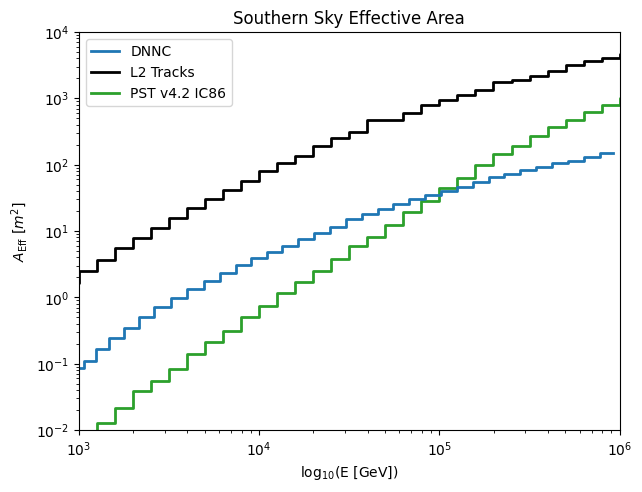

In [11]:
fig,ax = plt.subplots(facecolor='w')
effa_plot_notlogged(ax, mc, deg_min=-90, deg_max=-5, label='L2 Tracks')
effa_plot_notlogged_PST(ax, mc_pst, deg_min=-90, deg_max=-5, label='PST v4.2 IC86', color='C2')
plt.step(dnnc_effa_logE, dnnc_effa_effa, label='DNNC', linewidth=2)
plt.title('Southern Sky Effective Area')
plt.legend()
plt.xlim(1e3,1e6)
plt.ylim(1e-2,1e4)
plt.show()

In [5]:
h2d.values.T.shape

(49, 25)

In [27]:
sindec_bins = h2d.bins[1]
logE_bins = h2d.bins[0]
effa = h2d.values.T
livetime = 31371977.196272973 #2020 in seconds good time

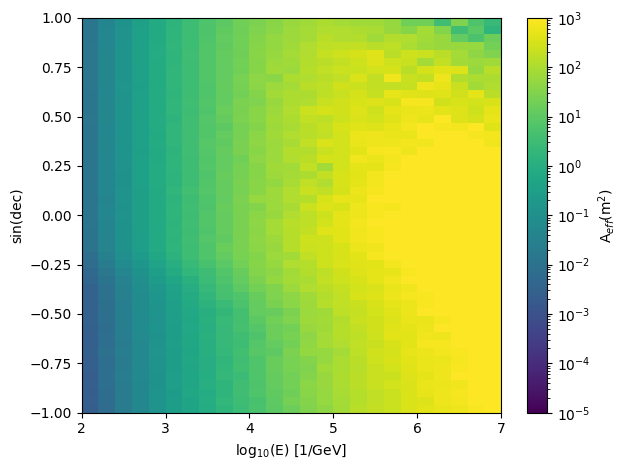

In [6]:
#Visualize
fig, ax = plt.subplots()
hl.plot2d(ax, h2d, cbar=True, clabel='A$_{eff}$(m$^2$)', log=True, vmin=1e-5, vmax=1e3)
ax.set_yticks(np.arange(-1,1.01,.25))
ax.set_ylabel('sin(dec)')
ax.set_xlabel('log$_{10}$(E) [1/GeV]')
ax.set_title('')
#ax.set_aspect('equal')
plt.tight_layout()

In [28]:
#From GPFluxMeasurement.ipynb
def acceptance_correct_pi0(
            ns, template, eff_area, sindec_bins, energy_bins,
            livetime, gamma, units
        ):
    """Convert a number of signal events to the corresponding flux

    Parameters
    ----------
    ns : array_like
        The number of signal events that will be converted to the
        corresponding flux.
    template : array_like
        The spatial template in units of sr^-1.
        Shape: [npix]
    eff_area : array_like
        The effective area binned in sin(dec) (unitless) along first
        dimension and and in energy (in GeV) along the second axis.
        shape: [n_bins_sindec, n_bins_energy]
    sindec_bins : array_like
        The bin edges along the first dimension corresponding to sin(dec).
        Shape: [n_bins_sindec + 1]
    energy_bins : TYPE
        The bin edges along the second dimension corresponding to
        the energy in GeV.
        Shape: [n_bins_energy + 1]
    livetime : float
        The livetime of the dataset in seconds.
        For the 10-year cascade dataset, the livetime corresponds to
        304047105.0735066 seconds, which is the default value.

    Returns
    -------
    array_like
        The flux in terms of E^2 dN/dE at 100 TeV in units
        of TeV cm^-2 s^-1.
    """

    npix = len(template)
    nside = hp.npix2nside(npix)
    
    # First we need to construct Phi(sindec, energy)
    # in units of GeV^-1 cm^-2 s^-1 sr^-1.
    # We will do this by splitting Phi into the spatial term (units of sr^-1)
    # and the energy term (units of GeV^-1 cm^-2 s^-1).
    # We can do this splitting for the pi0 model because the energy spectrum
    # is assumed not to depend on the location in the sky
    theta, phi = hp.pix2ang(nside, np.r_[:npix])
    pix_dec = np.pi/2. - theta
    pix_ra = phi
    pix_sindec = np.sin(pix_dec)

    # Phi(sindec), shape: [n_sindec], units of sr^-1
    phi_sindec = np.zeros(len(sindec_bins)-1)

    # walk through each declination band
    for i, sindec_max in enumerate(sindec_bins[1:]):
        sindec_min = sindec_bins[i]

        # get all pixels belonging to this dec band
        mask_pixels = np.logical_and(
            pix_sindec >= sindec_min,
            pix_sindec < sindec_max,
        )
        phi_sindec[i] = np.sum(template[mask_pixels])

    # Sky-integrated, per-flavor (nu + nubar) flux
    # Choose an arbitrary flux normalization to scale
    norm = 1e-18  # in units of GeV^-1 cm^-2 s^-1
    e0 = 1e5  # 100 TeV in units of GeV
    #gamma = 2.5

    # compute average energy in each energy bin
    energy_avg = (
        (-gamma + 1) / (-gamma + 2) *
        (energy_bins[1:]**(-gamma+2) - energy_bins[:-1]**(-gamma+2)) /
        (energy_bins[1:]**(-gamma+1) - energy_bins[:-1]**(-gamma+1))
    )

    # Phi(energy) in units of GeV^-1 cm^-2 s^-1
    # shape: [n_energy]
    phi_e = norm * (energy_avg / e0) ** (-gamma)

    # Phi(sindec, energy)
    # shape: [n_sindec, n_energy],  GeV^-1 cm^-2 s^-1 sr^-1
    phi = phi_e[np.newaxis] * phi_sindec[:, np.newaxis]

    # "integrate" over energy bin width
    # shape: [n_sindec, n_energy], cm^-2 s^-1 sr^-1
    phi *= np.diff(energy_bins)[np.newaxis]

    # "integrate" over solid angle
    # shape: [n_pix, n_bins], s^-1 * cm^-2
    phi *= hp.nside2pixarea(nside)

    # Now we can compute the total number of expected events
    # for the given flux.
    # eff_area is in units of cm^2 and livetime in units of s
    total_acceptance = livetime * np.sum(eff_area * phi)

    # we can then compute the ratio of the number of signal events versus
    # the number of events one would have expected based on the previously
    # defined flux. This can then be used to scale the arbitrary flux
    # normalization that we chose as a reference point.
    model_norm = ns / total_acceptance

    # compute E^2 dN/dE at 100 TeV in units of ...
    if units == 'GeV':
        norm_gev = norm # in units of GeV^-1 cm^-2 s^-1
        norm_E2 = norm_gev * (100000)**2
    elif units == 'TeV':
        norm_tev = norm * 1e3 # in units of TeV^-1 cm^-2 s^-1
        norm_E2 = norm_tev * (100)**2
    return model_norm*norm_E2

In [30]:
ns = 5e7
flux = acceptance_correct_pi0(
            ns, template, effa, sindec_bins, logE_bins,
            livetime=livetime, gamma=2.7, units='TeV',
        )
print(flux)

3.5769698574362618e-12


In [25]:
flux / np.sqrt(10)

2.7147292491039268e-12

In [ ]:
#Need to check flux conversion: Should effa have 1/1e4 factor for cm^2 to m^2 conversion?